In [1]:
# %load sim_visibility.py
import numpy as np, itertools, os
import cupy as cp
import itertools
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from tqdm import tqdm
from scipy import stats

import astropy.units as u
import astropy.constants as cst

from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time

In [3]:
from utils_telescope.simulate_visibility import compute_visibility, get_baselines
from utils_telescope.utils_sky import gaussian_2d, galactic_synch_fg_custom

In [4]:
print('------ Define Telescope ------')
# Loading the telescope and station layout coords:
telescope_layout = np.loadtxt('./layouts/skalow_AAstar_layout.txt') * u.m
station_layout = np.loadtxt('./layouts/station_layout.txt') * u.m

N_ant = telescope_layout.shape[0]
N_B = int(N_ant*(N_ant-1)/2)

print(' number of stations:', N_ant)
print(' number of baselines:', N_B)

freq = 166. * u.MHz
lam = (cst.c / freq).to('m')
z = 1.42*u.GHz/freq - 1.
print(' frequency [MHz]:', freq)
print(' wavelength [m]:', lam)
print(' redshift:', z)

uv_coord, uv_length = get_baselines(N_ant=N_ant, wavelength=lam, layout=telescope_layout)

------ Define Telescope ------
 number of stations: 307
 number of baselines: 46971
 frequency [MHz]: 166.0 MHz
 wavelength [m]: 1.8059786626506023 m
 redshift: 7.554216867469879


Calculate baselines: 100%|█████████████| 46971/46971 [00:00<00:00, 61295.74it/s]


In [5]:
# Declination
dec = -30. * u.deg

# integration time
int_time = (10.*u.s).to('h')

# Radial angle, Hour angle window
h_angle = np.arange(-2, 2, int_time.value) * u.hourangle

time_steps = h_angle.size
t_obs = h_angle.max()-h_angle.min()

print('Observation length :', t_obs)
print('Integration time :', int_time.to('s'))
print('Number of time steps : ', time_steps)

Observation length : 3.997222222222208 hourangle
Integration time : 10.0 s
Number of time steps :  1440


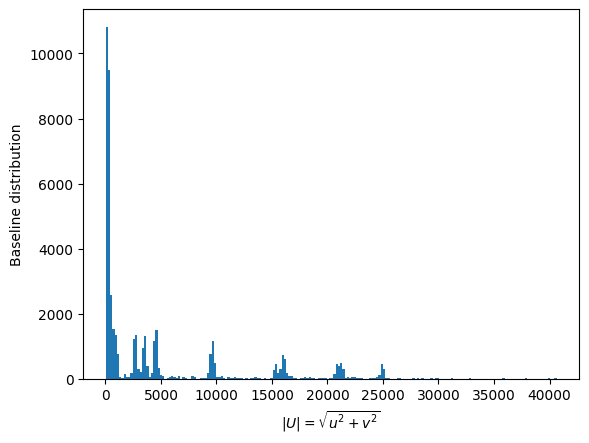

In [6]:
plt.hist(uv_length, bins=200);
plt.xlabel(r'$|U| = \sqrt{u^2 + v^2}$'), plt.ylabel('Baseline distribution')
plt.show()

In [7]:
print('------ Antenna Parameters ------')
D = np.linalg.norm(station_layout, axis=1).max()*2
print(' dish diameter [m]:', D)

theta_fwhm = (1.03 * lam / D) * u.rad
theta_0 = 0.6 * theta_fwhm
V_0 = (np.pi * theta_0**2 / 2).to('sr')
N_pix = 256
print(' theta_fwhm:', theta_fwhm)
print(' theta_0:', theta_0)
print(' V_0:', V_0)

print('\n------ Observational Quantities ------')
FoV = np.sqrt(V_0).to('rad')
print(' FoV:', FoV.to('deg'))

#--------------------------------------------------
# define a 1D sky and get RA coordinate
thet = np.linspace(-FoV/2, FoV/2, N_pix).to('rad').value
dthet = np.diff(thet)[0] # rad
print(' dthet:', (dthet*u.rad).to('arcsec'))

# Create a grid of points (we ignore third dimension, i.e. n-axis)
l_coord, m_coord = np.meshgrid(thet, thet)
lmn_coord = np.dstack((l_coord, m_coord)).reshape(-1, 2)

# Create a beam pattern
beam_pattern = np.exp(-((l_coord**2 + m_coord**2) / theta_0.value**2))

------ Antenna Parameters ------
 dish diameter [m]: 38.06656275525806 m
 theta_fwhm: 0.048865930829890346 rad
 theta_0: 0.029319558497934207 rad
 V_0: 0.0013503138730938376 sr

------ Observational Quantities ------
 FoV: 2.105426074955234 deg
 dthet: 29.72366223466223 arcsec


In [34]:
print('\n------ Define Sky Model ------')
L_box = FoV.to('rad').value * (1+z)*cosmo.angular_diameter_distance(z)

# Get the sky model
dT_jy = gaussian_2d(prefactor=1e-3, x=l_coord, y=m_coord, mean=np.array([0.005, -0.004]), cov=np.array([[(8e-1*u.arcsec).to('rad').value, 0], [0, (1e-1*u.arcsec).to('rad').value]]))
#dT_jy = galactic_synch_fg_custom(z=[z], ncells=N_pix, boxsize=L_box.value, A150=513., beta_=2.34, rseed=918)
#dT_jy = np.random.normal(loc=1e-3, scale=1e-4, size=(N_pix, N_pix))/1e4
#dT_jy += np.random.normal(loc=1e-3, scale=1e-4, size=(N_pix, N_pix))/1e4

print(' Boxsize:', L_box)


------ Define Sky Model ------
 Boxsize: 330.573531325587 Mpc


In [35]:
%%time

#max_b = (2*u.km/lam).cgs.value

vis, uvw_norms, uvw = compute_visibility(uvw=uv_coord, 
                                         lmn=lmn_coord, 
                                         I_sky=dT_jy, 
                                         beam_pattern=None, 
                                         flat_sky=False, 
                                         max_norm=None, 
                                         chunk_size=1024)

CPU times: user 5.01 s, sys: 1.72 ms, total: 5.01 s
Wall time: 5.01 s


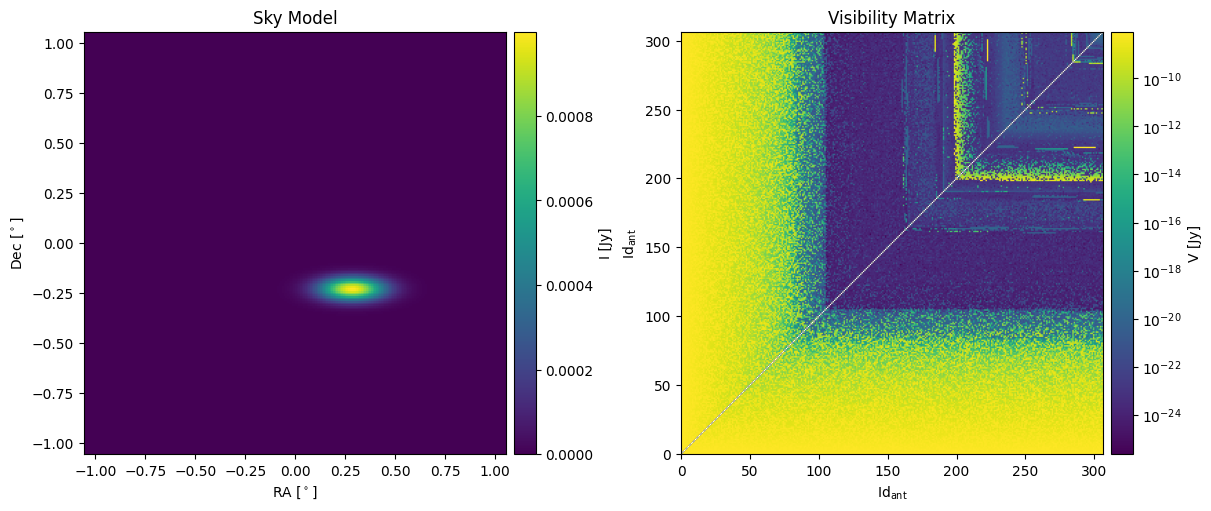

(None, None)

<Figure size 640x480 with 0 Axes>

In [36]:
# Define visibilities matrix
pair_comb_sort = list(itertools.combinations(range(N_ant), 2))

V_matrix = np.zeros((N_ant, N_ant))

for i_b in range(N_B):
    ii, jj = pair_comb_sort[i_b]

    # store visibility matrix
    V_matrix[ii, jj] = np.abs(vis[i_b])

# pairs are only for one corner
V_matrix = V_matrix + np.conj(V_matrix.T)

# plot visibility matrix
fig, axs = plt.subplots(figsize=(12, 5), ncols=2, nrows=1, constrained_layout=True)
axs[0].set_title('Sky Model')
#im = axs[0].pcolormesh((l_coord*u.rad).to('deg').value, (m_coord*u.rad).to('deg').value, dT_jy, vmin=0., vmax=0.002, cmap='viridis')
im = axs[0].pcolormesh((l_coord*u.rad).to('deg').value, (m_coord*u.rad).to('deg').value, dT_jy, vmin=0., cmap='viridis')
axs[0].set_xlabel(r'RA [$^\circ$]'), axs[0].set_ylabel(r'Dec [$^\circ$]')
plt.colorbar(im, ax=axs[0], label='I [Jy]', pad=0.01)

axs[1].set_title('Visibility Matrix')
im = axs[1].imshow(V_matrix, origin='lower', cmap='viridis', norm=LogNorm())
axs[1].set_xlabel(r'Id$_\mathrm{ant}$'), axs[1].set_ylabel(r'Id$_\mathrm{ant}$')
plt.colorbar(im, ax=axs[1], label='V [Jy]', pad=0.01)
plt.show(), plt.clf()

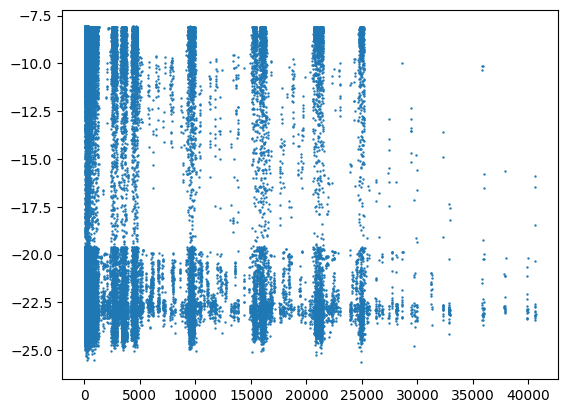

In [37]:
plt.scatter(uv_length, np.log10(np.abs(vis)), s=0.5);
#plt.xlabel(r'$|U| = \sqrt{u^2 + v^2}$'), plt.ylabel('Baseline distribution')
#plt.yscale('log')
plt.show()

1416


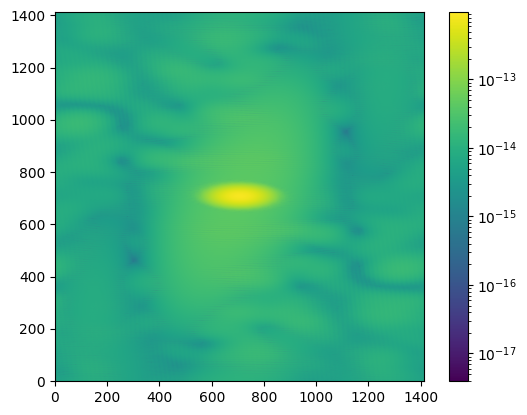

In [38]:
UMAX = 17000.
URES = 12.
USIZE = int(UMAX / URES)
print(USIZE)

u_bin = np.linspace(-UMAX, UMAX, USIZE, endpoint=False)

# binn the visibility points
uv_plane = stats.binned_statistic_2d(x=uvw[:,0], y=uvw[:,1], 
                                     values=np.abs(vis), statistic='sum', bins=[u_bin, u_bin]).statistic

uv_sampl = stats.binned_statistic_2d(x=uvw[:,0], y=uvw[:,1], 
                                     values=None, statistic='count', bins=[u_bin, u_bin]).statistic

uv_plane /= np.where(uv_sampl > 0, uv_sampl, 1)

I_sky_reconstruct = np.abs(np.fft.ifft2(uv_plane))
I_sky_reconstruct = np.fft.fftshift(np.abs(I_sky_reconstruct))

plt.imshow(I_sky_reconstruct.T, origin='lower', norm='log')
plt.colorbar()

In [126]:
np.abs(vis).size

130816

In [113]:
np.sqrt(vis.real**2+vis.imag**2)

array([1.75902337e-07, 1.06696708e-07, 1.18942513e-07, ...,
       1.05093662e-09, 1.17731681e-09, 4.87917338e-10])